In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

2025-01-18 13:54:00.647767: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Paths
dataset_csv = "/home/riashad/projects/final-thesis/dataset/csv/final_dataset.csv"

In [3]:
# Parameters
batch_size = 32
image_size = (224, 224)
num_classes = 3
learning_rate = 1e-4
epochs = 30

In [4]:
# Load CSV and split data
df = pd.read_csv(dataset_csv)
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

In [5]:
# Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image_path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image_path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,  # Ensure proper evaluation
)

Found 4730 validated image filenames belonging to 3 classes.
Found 1183 validated image filenames belonging to 3 classes.


In [6]:
# Build the Model
base_model = DenseNet121(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)  # Add another dropout layer
predictions = Dense(num_classes, activation="softmax")(x)

In [7]:
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

In [9]:
# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [10]:
# Callbacks
checkpoint = ModelCheckpoint(
    "DenseNet121.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

callbacks = [checkpoint, early_stopping, lr_scheduler]


In [11]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,
)

/home/riashad/anaconda3/envs/ml/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 529s 4s/step - accuracy: 0.3903 - loss: 1.4985 - val_accuracy: 0.8487 - val_loss: 0.5335 - learning_rate: 1.0000e-04
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 568s 4s/step - accuracy: 0.6362 - loss: 0.8498 - val_accuracy: 0.8766 - val_loss: 0.4218 - learning_rate: 1.0000e-04
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 570s 4s/step - accuracy: 0.7219 - loss: 0.6692 - val_accuracy: 0.8833 - val_loss: 0.3823 - learning_rate: 1.0000e-04
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 571s 4s/step - accuracy: 0.7555 - loss: 0.5934 - val_accuracy: 0.8884 - val_loss: 0.3515 - learning_rate: 1.0000e-04
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 567s 4s/step - accuracy: 0.7783 - loss: 0.5419 - val_accuracy: 0.8825 - val_loss: 0.3393 - learning_rate: 1.0000e-04
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 603s 4s/step - accuracy: 0.7899 - loss: 0.5325 - val_accuracy: 0.8876 - val_loss: 0.3317 - learning_rate: 1.0000e-04
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 667s 5s/step - acc

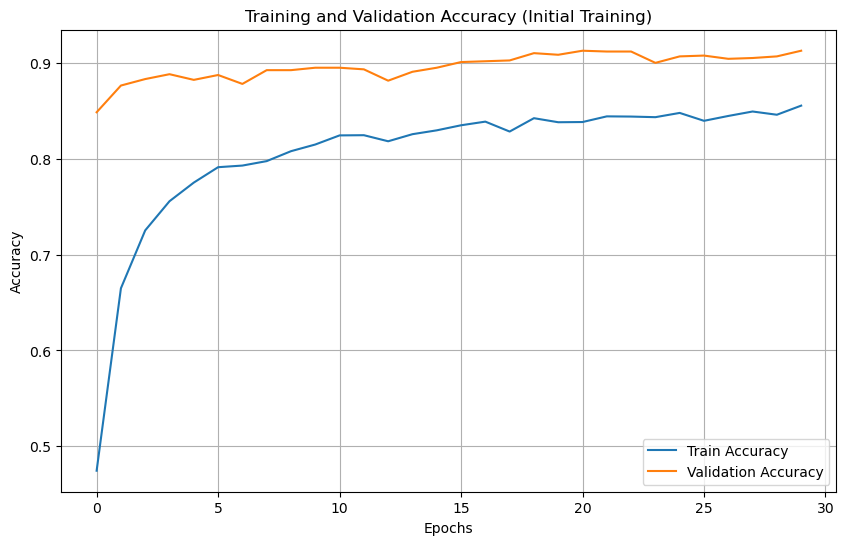

In [12]:
# Visualize Initial Training Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Initial Training)')
plt.legend()
plt.grid()
plt.show()

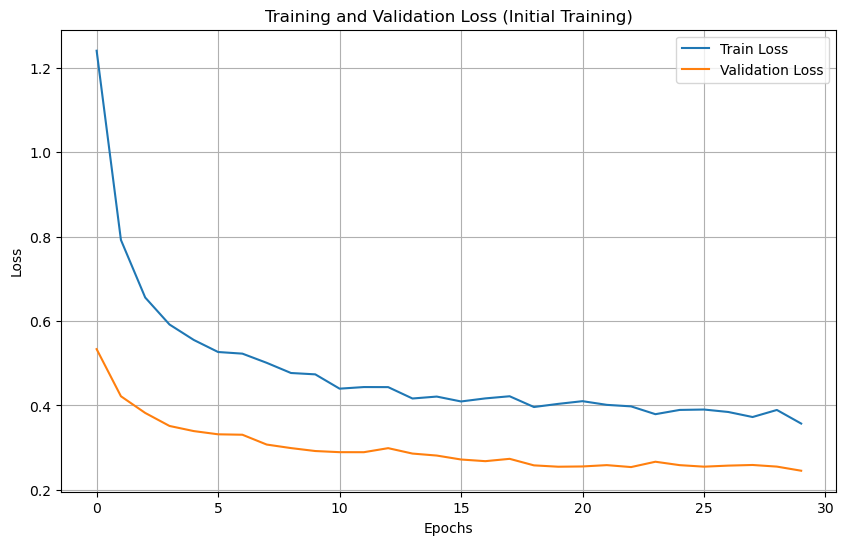

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Initial Training)')
plt.legend()
plt.grid()
plt.show()

In [14]:
# Unfreeze and Fine-tune
for layer in base_model.layers:
    layer.trainable = True

In [15]:
# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [16]:
# Fine-tune
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs // 2,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 2776s 18s/step - accuracy: 0.7072 - loss: 0.7955 - val_accuracy: 0.9087 - val_loss: 0.2298 - learning_rate: 1.0000e-05
Epoch 2/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 2541s 17s/step - accuracy: 0.8373 - loss: 0.4152 - val_accuracy: 0.9138 - val_loss: 0.2177 - learning_rate: 1.0000e-05
Epoch 3/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 2565s 17s/step - accuracy: 0.8825 - loss: 0.3156 - val_accuracy: 0.9138 - val_loss: 0.2128 - learning_rate: 1.0000e-05
Epoch 4/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 2583s 17s/step - accuracy: 0.8897 - loss: 0.2921 - val_accuracy: 0.9146 - val_loss: 0.2111 - learning_rate: 1.0000e-05
Epoch 5/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 2606s 18s/step - accuracy: 0.9141 - loss: 0.2531 - val_accuracy: 0.9070 - val_loss: 0.2183 - learning_rate: 1.0000e-05
Epoch 6/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 2423s 16s/step - accuracy: 0.9176 - loss: 0.2416 - val_accuracy: 0.9121 - val_loss: 0.2034 - learning_rate: 1.0000e-05
Epoch 7/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 2431s 

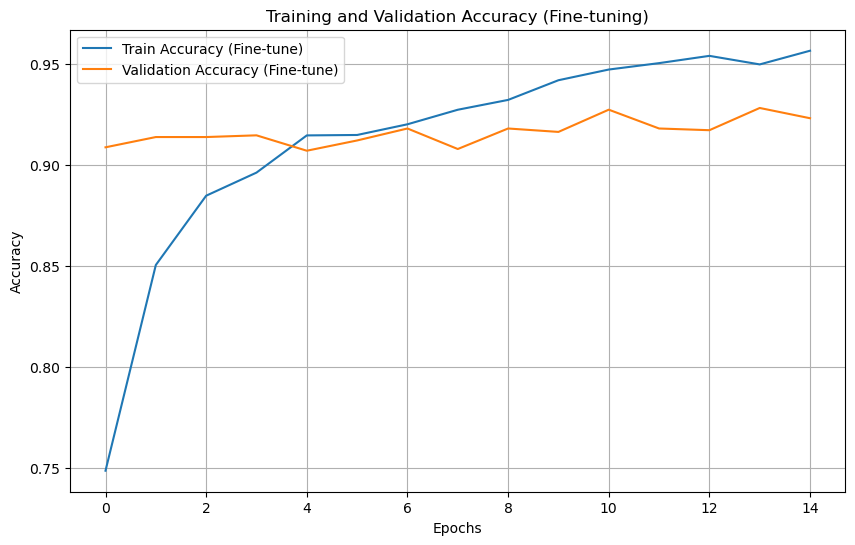

In [17]:
# Visualize Fine-tuning Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy (Fine-tune)')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy (Fine-tune)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Fine-tuning)')
plt.legend()
plt.grid()
plt.show()

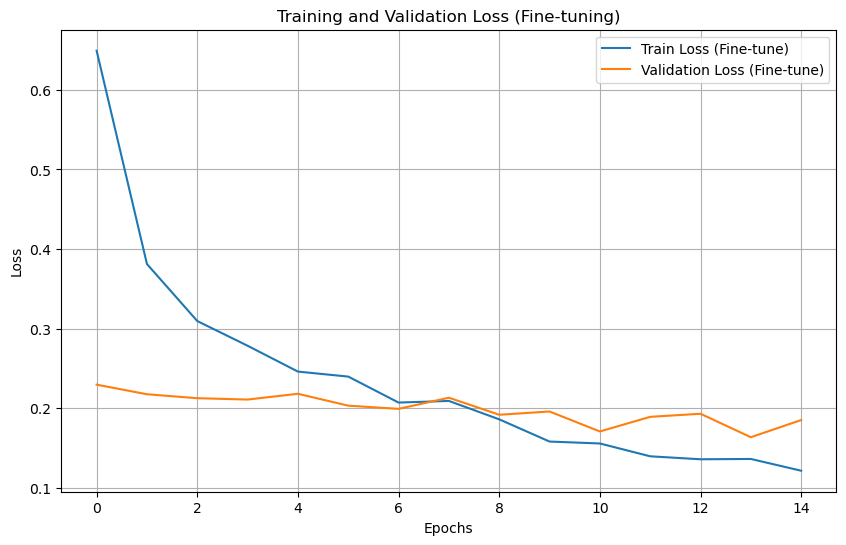

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(fine_tune_history.history['loss'], label='Train Loss (Fine-tune)')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss (Fine-tune)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Fine-tuning)')
plt.legend()
plt.grid()
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step


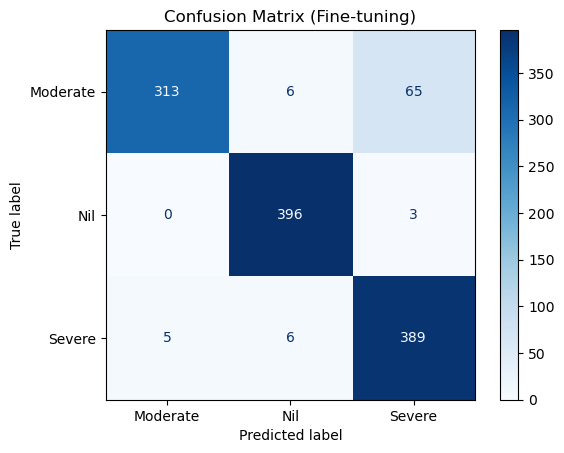

In [19]:
# Evaluation: Confusion Matrix and Classification Report
val_predictions = np.argmax(model.predict(val_generator), axis=-1)
val_labels = val_generator.classes  # Correctly retrieve true labels from the generator

cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix (Fine-tuning)')
plt.show()

In [20]:
report = classification_report(val_labels, val_predictions, target_names=val_generator.class_indices.keys())
print("Classification Report (Fine-tuning):\n", report)

Classification Report (Fine-tuning):
               precision    recall  f1-score   support

    Moderate       0.98      0.82      0.89       384
         Nil       0.97      0.99      0.98       399
      Severe       0.85      0.97      0.91       400

    accuracy                           0.93      1183
   macro avg       0.94      0.93      0.93      1183
weighted avg       0.93      0.93      0.93      1183



In [21]:
# Save the Fine-tuned Model
model.save("DenseNet121_finetuned.keras")